# Trajectory Analysis of DNA Catenanes

> 0. Install MDTraj package and import packages
> 1. Read the .gro and .xtc file
>>(1) __gmx trjconv -pbc nojump__ -f traj_pbc_mol.xtc -o traj_pbc_mol_pbc_nojump.xtc.
>
> 2. Check if there occurs any __molecular movement across the box boundaries__ due to the use of PBC.
>
> 3. If there are such cases, __calculate the trajectory again__ so that the box-crossing does not occur.
>
> 4. __Center the entire cystal__ at the middle of the simulation box.
>
> 5. __Write the .xtc file__
>> output file: <font color=royalblue>__traj_center_pbc_nojump.xtc__</font>.


## 0. Import MDTraj and import packages

In [1]:
!pip install mdtraj

import mdtraj as md

print(md.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 15.3 MB/s eta 0:00:00
1.11.0


In [2]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 1. Data import by git clone

In [3]:
!git clone https://github.com/junsookim76/DNA-Catenane-SI.git

Cloning into 'DNA-Catenane-SI'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 216 (delta 60), reused 29 (delta 29), pack-reused 126 (from 1)
Receiving objects: 100% (216/216), 145.14 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [5]:
# Confirm files

%cd /content/DNA-Catenane-SI/trajectory_for_visualization
!ls

/content/DNA-Catenane-SI/trajectory_for_visualization
conf_at76_at82_DNA_a.gro  traj_at76_at82_DNA_fit_1st_dt_10ns_a.xtc
conf_at76_at82_DNA_b.gro  traj_at76_at82_DNA_fit_1st_dt_10ns_b.xtc
conf_at82_at82_DNA_a.gro  traj_at82_at82_DNA_fit_1st_dt_10ns_a.xtc
conf_at82_at82_DNA_b.gro  traj_at82_at82_DNA_fit_1st_dt_10ns_b.xtc
conf_at92_at92_DNA_a.gro  traj_at92_at92_DNA_fit_1st_dt_10ns_a.xtc
conf_at92_at92_DNA_b.gro  traj_at92_at92_DNA_fit_1st_dt_10ns_b.xtc


In [6]:
# name for input file .gro
input_gro="./conf_at82_at82_DNA_a.gro"

# name for input file .xtc
input_xtc="./traj_at82_at82_DNA_fit_1st_dt_10ns_a.xtc"


In [8]:
!head -n 5 $input_gro

Protein in water
10496
    1DA       P    1  10.413  13.103  10.854  0.6920  0.4362  0.0579
    1DA     O1P    2  10.416  12.963  10.815  0.5550 -0.1439 -0.2982
    1DA     O2P    3  10.409  13.135  10.999 -0.0472 -0.0873  0.4409


## 2. Read .gro and .xtc File and the Topology Info

In [9]:
# Read .xtc File with .gro File
xtc=md.load_xtc(input_xtc,top=input_gro)

In [24]:
# natoms: number of atoms
natoms=xtc.n_atoms

# nbase: number of bases
nbase=xtc.n_residues

# nstrand: number of DNA strands
nstrand=4

# nbp: number of base pairs for each strand
nbp=round(nbase/nstrand)
ncirc = 2

# nsteps: number of frames
nsteps = xtc.n_frames

print('nsteps = %d'%nsteps)
print('nbp = %d'%nbp)

nsteps = 201
nbp = 82


In [15]:
# Topological Information

top=xtc.topology

table, bonds=top.to_dataframe()

atomname=table.values[:,1]

i=0
for ii in atomname:
    element[i] = ii[0]
    i += 1

print(element)
print(table)
print(atomname[:64])

['P' 'O' 'O' ... 'H' 'H' 'O']
       serial  name element  resSeq resName  chainID segmentID  formal_charge
0           1     P       P       1      DA        0                     <NA>
1           2   OP1       O       1      DA        0                     <NA>
2           3   OP2       O       1      DA        0                     <NA>
3           4   O5'      VS       1      DA        0                     <NA>
4           5   C5'      VS       1      DA        0                     <NA>
...       ...   ...     ...     ...     ...      ...       ...            ...
10491   10492   H3'      VS      82      DT        0                     <NA>
10492   10493   C2'      VS      82      DT        0                     <NA>
10493   10494  H2'1      VS      82      DT        0                     <NA>
10494   10495  H2'2      VS      82      DT        0                     <NA>
10495   10496   O3'      VS      82      DT        0                     <NA>

[10496 rows x 8 columns]
['P' 'OP

In [30]:
# xtc.xyz[프레임, 입자, xyz]
rxyz=np.array(xtc.xyz[:,:,:])
print('rxyz dimension = (%d, %d, %d)' %rxyz.shape)
print('rxyz type = ', type(rxyz))


rxyz dimension = (201, 10496, 3)
rxyz type =  <class 'numpy.ndarray'>


## 3. Atomic Masses
#### - at_mass: atomic mass (array of natoms)


In [35]:
# Initialization
at_mass=np.zeros(natoms)    # mass of each atom

for i in range(natoms):
    an1=element[i]
    if an1 == 'P':
        at_mass[i]=30.970
    elif (an1 == "C"):
        at_mass[i]=12.010
    elif (an1 == "O"):
        at_mass[i]=16.000
    elif (an1 == "N"):
        at_mass[i]=14.010
    else:
        at_mass[i]=1.008

print("number of atoms = %s" % natoms)

print("first 10 element = %s" %(element[:10]))
print("first 10 mass = %s" %(at_mass[:10]))


number of atoms = 10496
first 10 element = ['P' 'O' 'O' 'O' 'C' 'H' 'H' 'C' 'H' 'O']
first 10 mass = [30.97  16.    16.    16.    12.01   1.008  1.008 12.01   1.008 16.   ]


## 4. Calculating distance between the CoMs of two minicircles

In [53]:
natoms1 = int(np.size(rxyz[0,:,0]) / 2)
distance = np.zeros(nsteps, dtype=float)

for istep in range (nsteps):

    if istep %20 == 0:
        print('Step = %d'%istep)

    com1 = np.sum(at_mass[:natoms1, np.newaxis] * rxyz[istep,:natoms1,:], axis=0) / np.sum(at_mass[:natoms1])

    com2 = np.sum(at_mass[natoms1:, np.newaxis] * rxyz[istep,natoms1:,:], axis=0) / np.sum(at_mass[natoms1:])

    distance[istep] = np.linalg.norm(com2 - com1)
    if istep %20 == 0:
        print('  Distance between two minicircles (nm) = %f'%distance[istep])

    # print(com1)
    # print(com2)


Step = 0
  Distance between two minicircles (nm) = 4.244637
Step = 20
  Distance between two minicircles (nm) = 4.681243
Step = 40
  Distance between two minicircles (nm) = 4.452261
Step = 60
  Distance between two minicircles (nm) = 4.553059
Step = 80
  Distance between two minicircles (nm) = 3.838765
Step = 100
  Distance between two minicircles (nm) = 4.537061
Step = 120
  Distance between two minicircles (nm) = 4.238052
Step = 140
  Distance between two minicircles (nm) = 3.900191
Step = 160
  Distance between two minicircles (nm) = 4.276126
Step = 180
  Distance between two minicircles (nm) = 4.454848
Step = 200
  Distance between two minicircles (nm) = 4.823505


In [ ]:
com = np.zeros((np.size(xtc.xyz[0,:,0]),3), dtype=float)

natoms_minicircle1 = int(np.size(xtc.xyz[0,:,0]) / 2)

print('Number of atoms in minicircle 1 = %d'%natms_minicircle1)

distance_minicirc = np.zeros(nsteps, dtype=float)

for istep in range (nsteps):

    if istep %100 == 0:
        print('Step = %d'%istep)
    com[:,0] = xtc.xyz[istep,:,0]*at_mass
    com[:,1] = xtc.xyz[istep,:,1]*at_mass
    com[:,2] = xtc.xyz[istep,:,2]*at_mass

    #print(com)

    com_minicircle1 = np.sum(com[:natoms_minicircle1], axis=0) / mass_minicirc
    if istep %100 == 0:
            print('  CoM of Minicircle 1 (nm) = %s'%com_minicircle1)
    com_minicircle2 = np.sum(com[natoms_minicircle1:], axis=0) / mass_minicirc
    if istep %100 == 0:
        print('  CoM of Minicircle 2 (nm) = %s'%com_minicircle2)

    distance_minicirc[istep] = np.linalg.norm(com_minicircle2 - com_minicircle1)
    if istep %100 == 0:
        print('  Distance between two minicircles (nm) = %f'%distance_minicirc[istep])


Number of atoms in minicircle 1 = 5248
Step = 0
  CoM of Minicircle 1 (nm) = [12.55546174 14.54706342  6.90608716]
  CoM of Minicircle 2 (nm) = [16.79331674 14.79047343  6.93772388]
  Distance between two minicircles (nm) = 4.244958
Step = 100
  CoM of Minicircle 1 (nm) = [12.55104959 14.54527575  6.90398702]
  CoM of Minicircle 2 (nm) = [16.62894129 15.23589086  6.33514495]
  Distance between two minicircles (nm) = 4.174893
Step = 200
  CoM of Minicircle 1 (nm) = [12.54993556 14.54840578  6.90487746]
  CoM of Minicircle 2 (nm) = [17.19542525 15.15101498  6.96448313]
  Distance between two minicircles (nm) = 4.684791
Step = 300
  CoM of Minicircle 1 (nm) = [12.55267342 14.54482473  6.90561252]
  CoM of Minicircle 2 (nm) = [15.72980177 14.64133284  4.18194219]
  Distance between two minicircles (nm) = 4.185910
Step = 400
  CoM of Minicircle 1 (nm) = [12.55254303 14.54542337  6.90703815]
  CoM of Minicircle 2 (nm) = [16.34110326 14.72458465  4.56764828]
  Distance between two minicircles

In [54]:
print('Average distance (nm) = %f'%(np.mean(distance)))

Average distance (nm) = 4.327413


In [55]:
def set_fig():

    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=40)
    plt.rc('axes', labelsize=60) # fontsize of the x and y labels

#    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(right=0.95)

    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)


    ax.tick_params(which='major', bottom=True, top=True, left=True, right=True, length=15, width=3, direction="in", pad=20)
    ax.tick_params(which='minor', bottom=True, top=True, left=True, right=True, length=10, width=3, direction="in", pad=20)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)

NameError: name 'distance_minicirc' is not defined

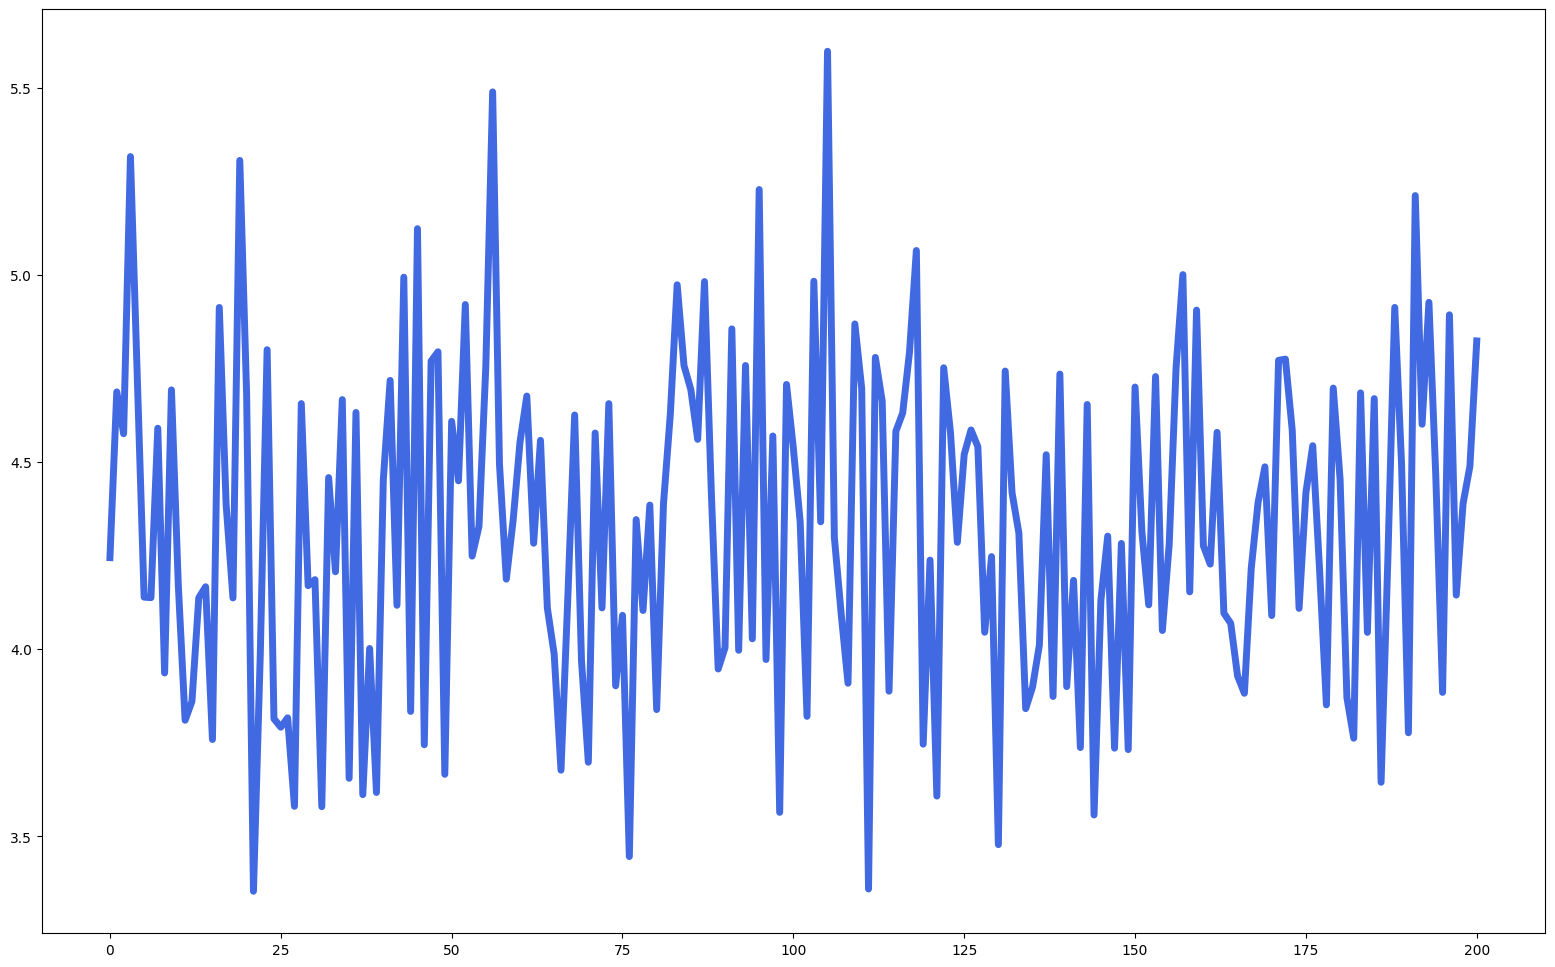

In [57]:
fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(np.arange(0, 201, 1), distance, label='82-82 Cat.', color='royalblue', linewidth=5)

plt.hlines(np.mean(distance), 0, 200, linewidth=5, linestyle='--', color='black', zorder = 3, label='Avg = %.2f nm'%np.mean(distance_minicirc))

plt.xlabel('Time (ns)', labelpad=30, fontsize=80)
plt.ylabel('Distance (nm)', labelpad=30, fontsize=80)

plt.xlim(0, 200)
plt.ylim(2.5, 6.5)

plt.xticks(np.arange(0, 201, 500))
plt.yticks(np.arange(2.0, 7.01, 1.0))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.98,0.98), prop={'size': 35}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('distance_com.png')


### 5. Distribution of the distance between the CoMs of two minicircles

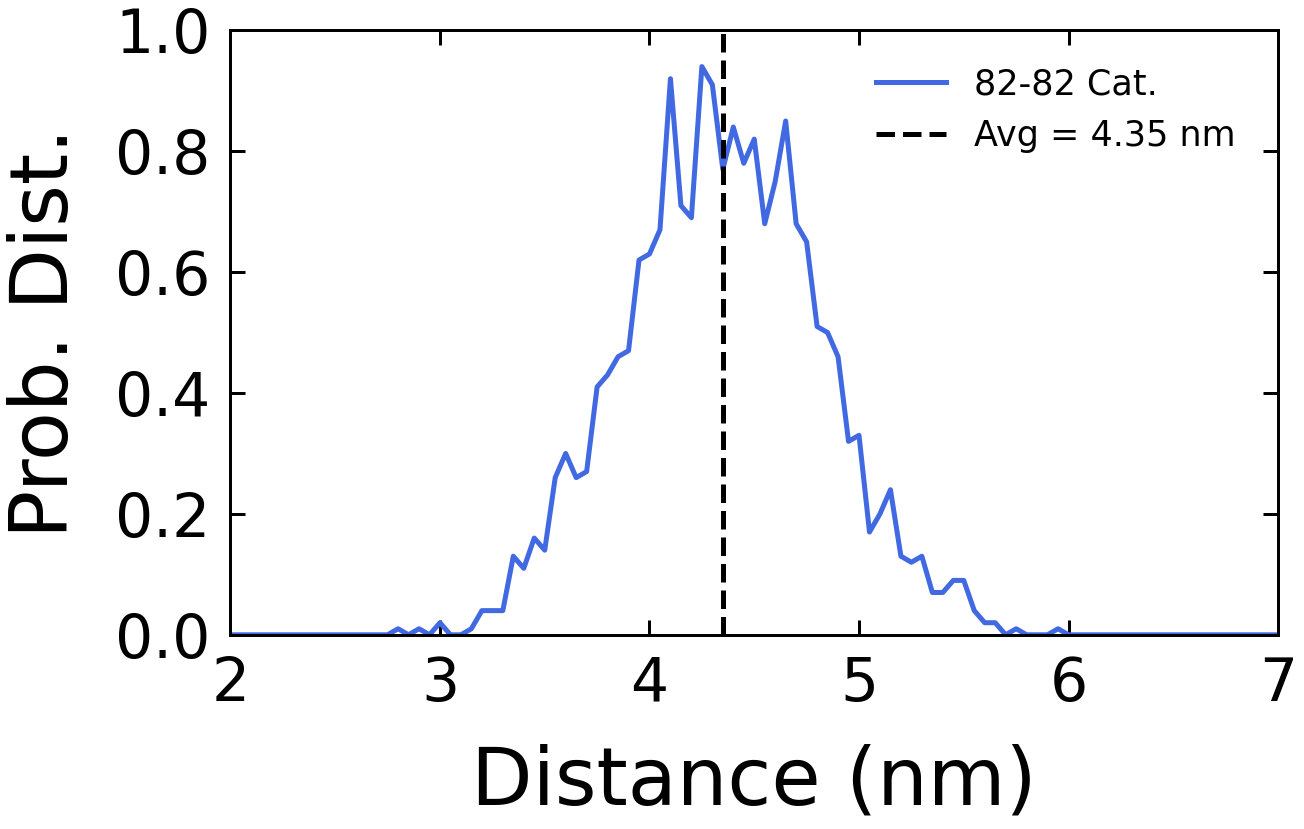

In [ ]:
width = 0.05
width_2 = width * 0.5
init  = 2.0
fin   = 7.0
fin_i = int((fin - init)/width + 1.0)
distrb_x = np.arange(init, fin+width, width)
distrb_y = np.zeros(fin_i, dtype=float)

distrb_com = np.trunc((distance_minicirc + width_2 - init) / width)
for i in range (fin_i):
    distrb_y[i] += np.count_nonzero(distrb_com == i)

distrb_y /= nsteps*width

fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(distrb_x, distrb_y, label='82-82 Cat.', color='royalblue', linewidth=5)

plt.vlines(np.mean(distance_minicirc), 0, 1, linewidth=5, linestyle='--', color='black', zorder = 3, label='Avg = %.2f nm'%np.mean(distance_minicirc))

plt.xlabel('Distance (nm)', labelpad=30, fontsize=80)
plt.ylabel('Prob. Dist.', labelpad=30, fontsize=80)

plt.xlim(2, 7)
plt.ylim(0, 1)

plt.xticks(np.arange(2.0, 7.1, 1))
plt.yticks(np.arange(0, 1.1, .2))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.99,0.99), prop={'size': 35}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('prob_distrb_distance_com.png')


In [ ]:
def gauss(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))

In [ ]:
x0 = distrb_x
y0 = distrb_y

popt0, pcov0 = curve_fit(gauss, x0, y0)

residuals0 = x0 - gauss(x0, *popt0)
ss_res0 = np.sum(residuals0**2)
ss_tot0 = np.sum((y0-np.mean(y0))**2)
r_squared0 = 1 - (ss_res0 / ss_tot0)

print('82-82 bp  : y = %f*np.exp(-(x-%f)**2/(2*%f**2)) --> R^2 = %f \n'
          % (popt0[0], popt0[1], popt0[2], r_squared0))

82-82 bp  : y = 0.854223*np.exp(-(x-4.349947)**2/(2*0.467821**2)) --> R^2 = -251.518675 



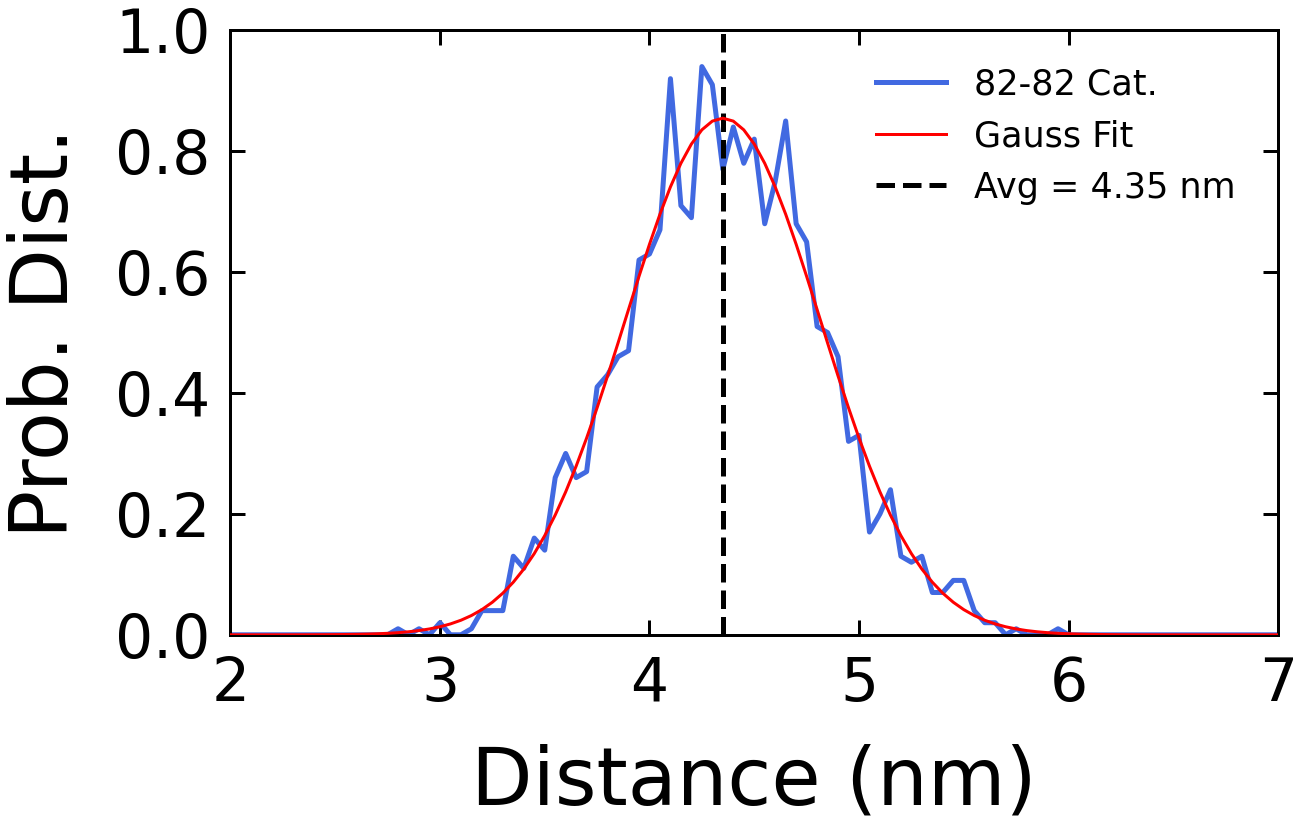

In [ ]:
fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(distrb_x, distrb_y, label='82-82 Cat.', color='royalblue', linewidth=5)

ax.plot(x0, gauss(x0, *popt0), linewidth= 3, color='red', zorder=5, label='Gauss Fit')

plt.vlines(np.mean(distance_minicirc), 0, 1, linewidth=5, linestyle='--', color='black', zorder = 3, label='Avg = %.2f nm'%np.mean(distance_minicirc))

plt.xlabel('Distance (nm)', labelpad=30, fontsize=80)
plt.ylabel('Prob. Dist.', labelpad=30, fontsize=80)

plt.xlim(2, 7)
plt.ylim(0, 1)

plt.xticks(np.arange(2.0, 7.1, 1))
plt.yticks(np.arange(0, 1.1, .2))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.99,0.99), prop={'size': 35}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('prob_distrb_distance_com_w_fit.png')


### 6. Time correlation of the distance between the CoMs of two minicircles

In [ ]:
def exp_dec(x, a):
    return np.exp(-(x)/(a))

In [ ]:
corr_time = 21 # ns

distance_for_corr = distance_minicirc -np.mean(distance_minicirc)
corr = np.zeros(corr_time, dtype=float)

for istep in range(nsteps - corr_time):
    for icorr in range (corr_time):
        corr[icorr] += distance_for_corr[istep] * distance_for_corr[istep+icorr]

corr /= (nsteps-corr_time)

corr /= corr[0]
#print(corr)


In [ ]:
x1 = np.arange(0, corr_time, 1)
y1 = corr

popt1, pcov1 = curve_fit(exp_dec, x1, y1)

residuals1 = x1 - exp_dec(x1, *popt1)
ss_res1 = np.sum(residuals1**2)
ss_tot1 = np.sum((y0-np.mean(y1))**2)
r_squared1 = 1 - (ss_res1 / ss_tot1)

print('82-82 bp  : y = np.exp(-x/%f) --> R^2 = %f \n'
          % (popt1[0], r_squared1))


82-82 bp  : y = np.exp(-x/3.833344) --> R^2 = -340.249694 



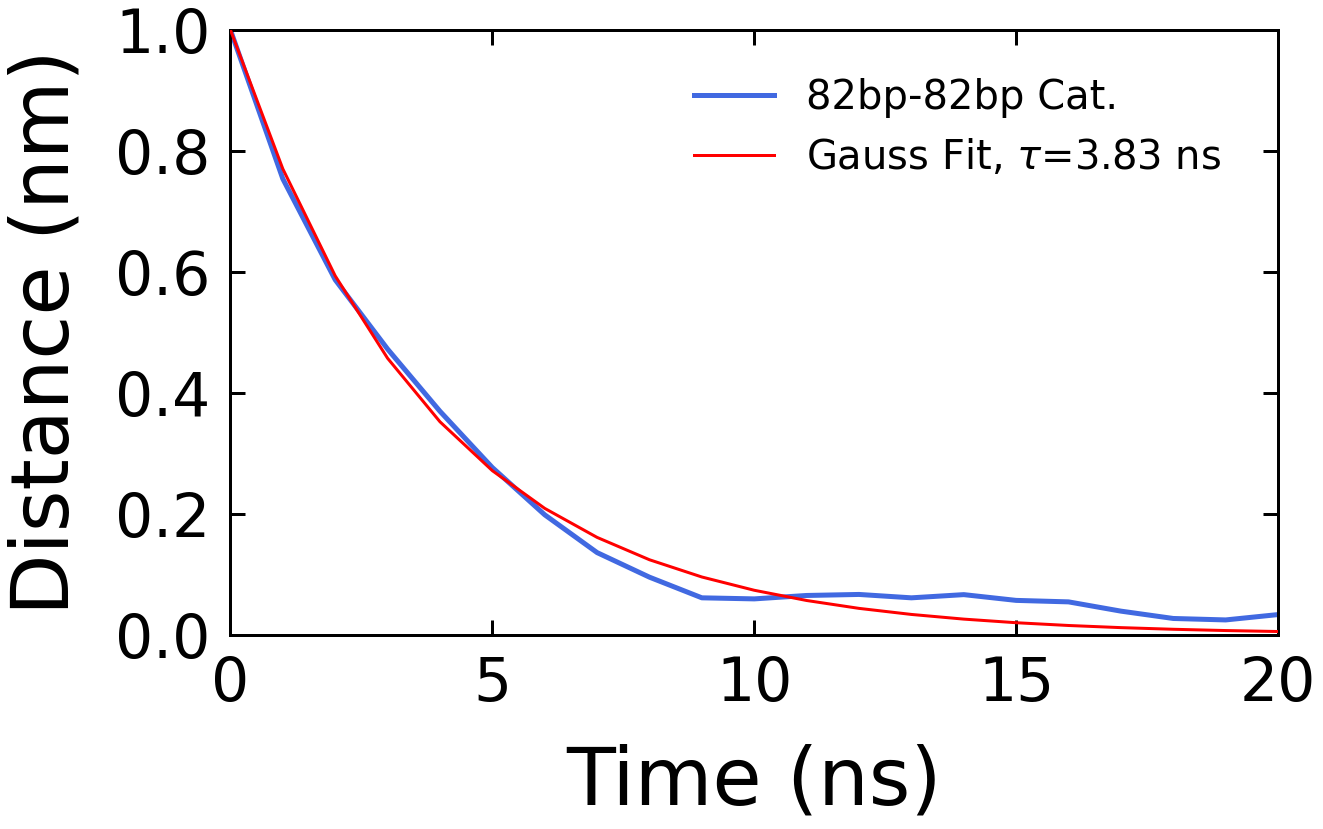

In [ ]:
fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(np.arange(0, corr_time, 1), corr, label='82bp-82bp Cat.', color='royalblue', linewidth=5)

ax.plot(x1, exp_dec(x1, *popt1), linewidth= 3, color='red', zorder=5, label=r'Gauss Fit, $\tau$=%.2f ns'%popt1[0])

#plt.hlines(0.5, 0, popt0[0], linewidth=2, linestyle='--', color='black', zorder = 1)
#plt.vlines(popt0[0], 0, 0.5, linewidth=2, linestyle='--', color='black', zorder = 1)

plt.xlabel('Time (ns)', labelpad=30, fontsize=80)
plt.ylabel('Distance (nm)', labelpad=30, fontsize=80)

plt.xlim(0, 20)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 21, 5))
plt.yticks(np.arange(0.0, 1.01, 0.2))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.98,0.98), prop={'size': 40}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('time_corr_distance_com_w_fit.png')

#plt.savefig('dist_8282_com_curv.pdf')